This noteboook contains R code to produce Figure 1 - model performance in held-out dataset

In [0]:
%r
library(SparkR)

# Read in held-out test dataset
test_df <- read.df(path = "/mnt/stage-delta-lake/ds/applied_data_science/ed_insights_pub/bhe_vae_knn_v42_test")
test_df <- as.data.frame(test_df)

# rename a few columns
test_df$y <- test_df[["30_days_label"]]
test_df[['30_days_label']] <- NULL

test_df$cancer_type_breast_cancer <- test_df[["cancer_type_breast-cancer"]]
test_df[['cancer_type_breast-cancer']] <- NULL

# get patient cancer type from problems and condition
cancer_types <- read.df(path="/mnt/stage-delta-lake/ds/applied_data_science/ed_insights_pub/cancer_types_from_conditions_problems")
cancer_types <- as.data.frame(cancer_types)

# make lists of breast and GU MRNs
breast_mrns <- unique(cancer_types[cancer_types$cancer_group == "Breast Cancer",]$mrn)
gu_mrns <- unique(cancer_types[cancer_types$cancer_group == "GU Cancer",]$mrn)
all_mrns <- unique(cancer_types$mrn)

#exclude mrns in common to both lists
breast_mrns <- breast_mrns[!(breast_mrns %in% gu_mrns)]
gu_mrns <- gu_mrns[!(gu_mrns %in% breast_mrns)]
other_mrns <- all_mrns[!(all_mrns %in% gu_mrns) & !(all_mrns %in% breast_mrns)]

In [0]:
%r
library(ggplot2)
library(pROC)
library(tidyverse)

install.packages("cowplot")
library(cowplot)

ronin_colors <- c("#315677", "#3392c0", "#b5d5e7", "#ffab40", "#637176", "#980000")

# number of bootstraps to use for calibration plot CI
n_cal_boot <- 100

# xlim for plotting and AUC
auc_xvals <- c(0.5, 0.9)


* installing *source* package ‘cowplot’ ...
** package ‘cowplot’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (cowplot)
 Installing package into ‘/local_disk0/.ephemeral_nfs/envs/rEnv-a0f27015-961e-429b-8205-c3a333e582df’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/cowplot_1.1.1.tar.gz'
Content type 'application/x-gzip' length 1353271 bytes (1.3 MB)
==================================================
downloaded 1.3 MB


The downloaded source packages are in
	‘/tmp/RtmpRnHrm5/downloaded_packages’

In [0]:
%run ./calibration_utils

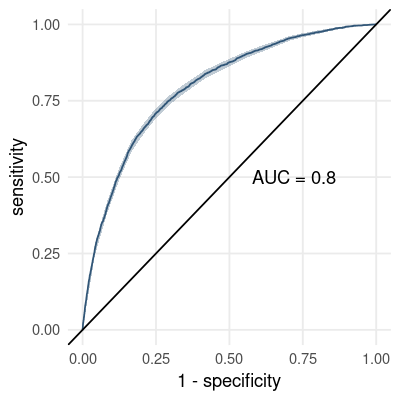

Setting levels: control = 0, case = 1
Setting direction: controls < cases

In [0]:
%r
# Figure 1a, ROC plot for entire test dataset

all.roc <- roc(test_df$y, test_df$prediction, ci=TRUE, ci.method="bootstrap")
all.ci <- ci.se(all.roc, specificities=seq(0, 1, l=25))
all.ci.df <- data.frame(
  x=as.numeric(rownames(all.ci)),
  lower = all.ci[,1],
  upper = all.ci[,3])

roc_p <- ggroc(all.roc, colour = ronin_colors[1], linetype=1, size=0.5, legacy.axes=TRUE) +
  theme_minimal() +
  geom_abline() +
  annotate(geom="text", label=paste0("AUC = ", format(all.roc$auc, digits=2)), x=0.72, y=0.5) +
  geom_ribbon(data=all.ci.df, aes(x=1-x, ymin=lower, ymax=upper), fill=ronin_colors[1], alpha=0.3) +
  theme(panel.grid.minor=element_blank())

options(repr.plot.width=400, repr.plot.height=400)
roc_p

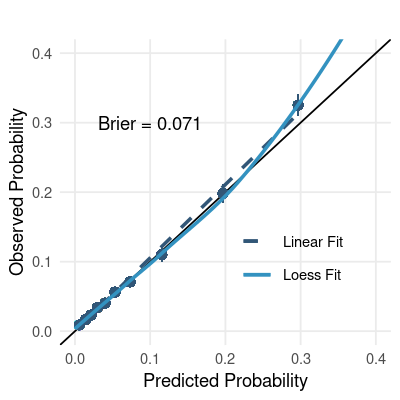

`geom_smooth()` using formula 'y ~ x'

In [0]:
%r
# Figure 1b, calbiration plot for entire test dataset

calibration_p <- plot_overall_calibration(test_df, n_bins=10, title="")

brier_val <- brier(test_df$prediction, test_df$y)
calibration_p <- calibration_p + annotate(geom="text", label=paste0("Brier = ", format(brier_val, digits=2)), x=0.1, y=0.3)

options(repr.plot.width=400, repr.plot.height=400)
calibration_p

In [0]:
%r
# function to calculate AUC for subgroups
calc_subgroup_roc <- function(df, col_name="race") {
    
  subgroup_levels <- levels(df[[col_name]])  
  n_subgroup <- length(subgroup_levels)
  
  output <- data.frame(
    label=rep(NA, n_subgroup),
    n=rep(NA, n_subgroup),
    estimate=rep(NA, n_subgroup),
    ci_lower=rep(NA, n_subgroup),
    ci_upper=rep(NA, n_subgroup)
  )
  
  for (i in 1:n_subgroup) {
    subgroup = subgroup_levels[i]
  
    subgroup_df <- df[df[[col_name]]==subgroup,]
    subgroup_roc <- roc(subgroup_df$y, subgroup_df$prediction, ci=TRUE, ci.method="bootstrap")
  
    output$label[i] <- subgroup
    output$n[i] <- nrow(subgroup_df)
    output$estimate[i] <- subgroup_roc$auc
    output$ci_lower[i] <- subgroup_roc$ci[1]
    output$ci_upper[i] <- subgroup_roc$ci[3]
  }
  return(output)
}

plot_subgroup <- function(df, title="", xvals=c(0.5, 0.9), xlab="AUC", include_x=TRUE, remove_unknown=FALSE) {
  
  if (remove_unknown==TRUE) {
    df <- df[df$label != "Unknown",]
  }
  
  p <- ggplot(df, aes(y=label, x=estimate)) + 
    geom_point(color=ronin_colors[1], size=2) +
    geom_errorbar(aes(xmin=ci_lower, xmax=ci_upper, width=0), color=ronin_colors[1]) +
    theme_minimal() +
    xlab(xlab) +
    ylab("") +
    xlim(values=xvals) +
    scale_y_discrete(limits=rev, labels=function(x) {strtrim(x, 6)}) +
    coord_cartesian(clip="off") +
    ggtitle(title) +
    theme(legend.position="none",
          plot.title=element_text(size=10),
          panel.grid.minor=element_blank())
  
  if (include_x==FALSE) {
    p <- p + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.title.x=element_blank())
  }
  
  return(p)
}

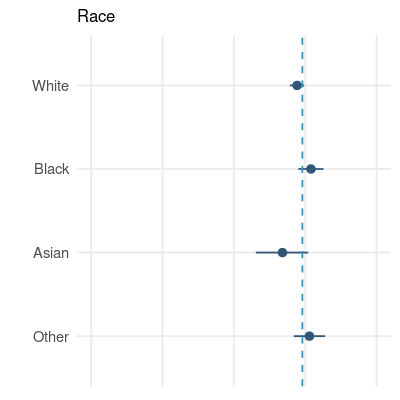

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases

In [0]:
%r
# Figure 1c - race subgroup AUC plot

# create race summary column
test_df <- test_df %>%
 mutate(race = case_when(
    race_vector_white_or_caucasian == 1 ~ "White",
    race_vector_asian == 1 ~ "Asian", 
    race_vector_black_or_african_american == 1 ~ "Black",
    race_vector_native_hawaiian_or_other_pacific_islander == 1 ~ "Other",
    race_vector_american_indian == 1 ~ "Other",
    race_vector_other == 1 ~ "Other", 
    TRUE ~ "Unknown"
 ))

race_levels <- c("White", "Black", "Asian", "Other", "Unknown")
test_df$race <- factor(test_df$race, levels=race_levels)

# calc auc by race
race_roc <- calc_subgroup_roc(test_df, col_name="race")
race_roc$label <- factor(race_roc$label, levels=race_levels)

# plot auc by race
race_auc_p <- plot_subgroup(race_roc, title="Race", remove_unknown=TRUE, xvals=auc_xvals, xlab="AUC", include_x=FALSE)
race_auc_p <- race_auc_p + geom_vline(xintercept=0.796, linetype=2, col=ronin_colors[2])

options(repr.plot.width=600, repr.plot.height=400)
race_auc_p

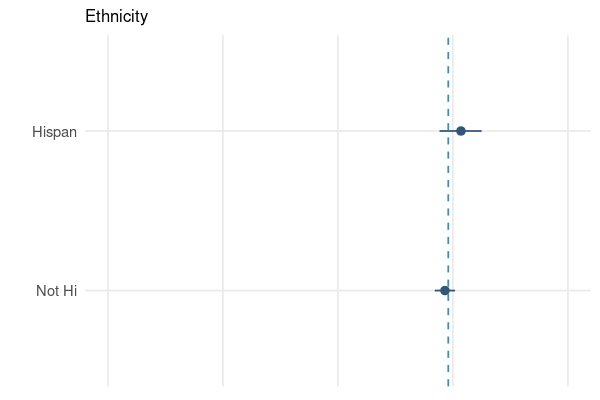

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases

In [0]:
%r
# Figure 1c - ethnicity subgroup AUC plot

# create ethnicity summary column
test_df <- test_df %>%
 mutate(ethnicity = case_when(
    ethnicity_vector_not_hispanic_or_latino == 1 ~ "Not Hispanic or Latino",
    ethnicity_vector_hispanic_or_latino == 1 ~ "Hispanic or Latino", 
    TRUE ~ "Unknown"
 ))

ethnicity_levels <- c("Hispanic or Latino", "Not Hispanic or Latino", "Unknown")
test_df$ethnicity <- factor(test_df$ethnicity, levels=ethnicity_levels)

# calc auc by ethnicity
ethnicity_roc <- calc_subgroup_roc(test_df, col_name="ethnicity")
ethnicity_roc$label <- factor(ethnicity_roc$label, levels=ethnicity_levels)

# plot auc by ethnicity
ethnicity_auc_p <- plot_subgroup(ethnicity_roc, title="Ethnicity", include_x=FALSE, remove_unknown=TRUE, xvals=auc_xvals, xlab="AUC")
ethnicity_auc_p <- ethnicity_auc_p + geom_vline(xintercept=0.796, linetype=2, col=ronin_colors[2])

options(repr.plot.width=600, repr.plot.height=400)
ethnicity_auc_p

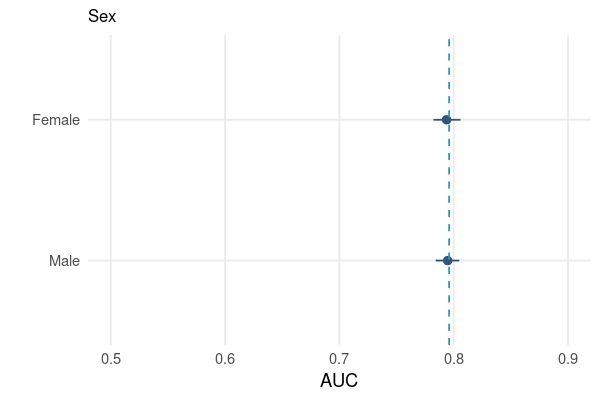

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases

In [0]:
%r
# Figure 1c - sex subgroup AUC plot

# create sex summary column
test_df <- test_df %>%
 mutate(sex = case_when(
    birthsex_vector_f == 1 ~ "Female",
    birthsex_vector_m == 1 ~ "Male",
    TRUE ~ "Unknown"
 ))

sex_levels <- c("Female", "Male")
test_df$sex <- factor(test_df$sex, levels=sex_levels)

# calc auc by sex
sex_roc <- calc_subgroup_roc(test_df, col_name="sex")
sex_roc$label <- factor(sex_roc$label, levels=sex_levels)

# plot auc by sex
sex_auc_p <- plot_subgroup(sex_roc, title="Sex", include_x=TRUE, xlab="AUC", xvals=auc_xvals)
sex_auc_p <- sex_auc_p + geom_vline(xintercept=0.796, linetype=2, col=ronin_colors[2])

options(repr.plot.width=600, repr.plot.height=400)
sex_auc_p

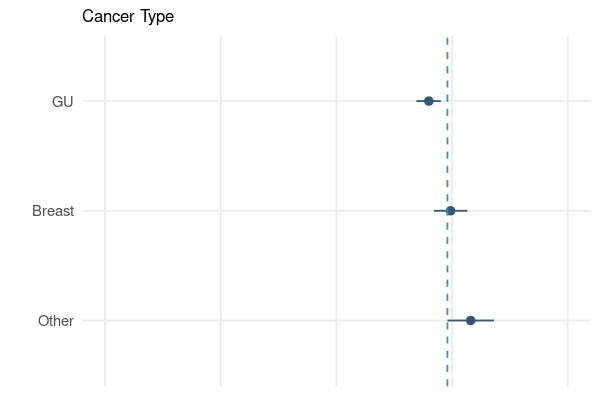

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases

In [0]:
%r
# Figure 1c - cancer type subgroup AUC plot

# create cancer type summary column
test_df <- test_df %>%
 mutate(cancer_type = case_when(
    mrn %in% gu_mrns ~ "GU",
    mrn %in% breast_mrns ~ "Breast", 
    mrn %in% other_mrns ~ "Other",
    TRUE ~ "Unknown"
 ))

cancer_type_levels <- c("GU", "Breast", "Other", "Unknown")
test_df$cancer_type <- factor(test_df$cancer_type, levels=cancer_type_levels)

# calc auc by cancer type
cancer_type_roc <- calc_subgroup_roc(test_df, col_name="cancer_type")
cancer_type_roc$label <- factor(cancer_type_roc$label, levels=cancer_type_levels)

# plot auc by cancer type
cancer_type_auc_p <- plot_subgroup(cancer_type_roc, title="Cancer Type", xlab="AUC", include_x=FALSE, remove_unknown=TRUE, xvals=auc_xvals)
cancer_type_auc_p <- cancer_type_auc_p + geom_vline(xintercept=0.796, linetype=2, col=ronin_colors[2])

options(repr.plot.width=600, repr.plot.height=400)
cancer_type_auc_p

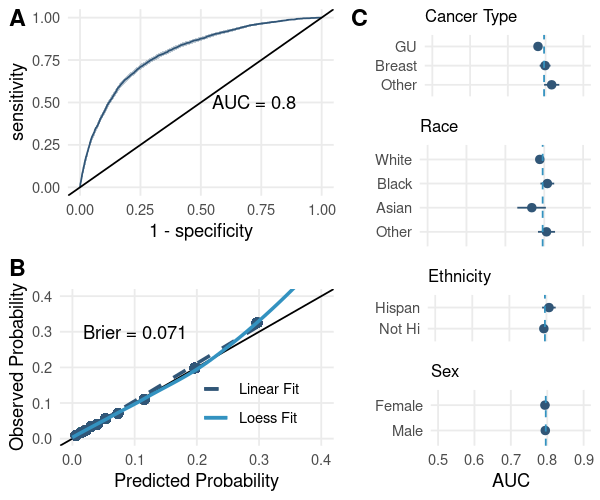

`geom_smooth()` using formula 'y ~ x'

In [0]:
%r
# combine all plots
options(repr.plot.width=600, repr.plot.height=500)
overall_p <- plot_grid(roc_p, calibration_p, ncol=1, labels=c("A", "B"))
subgroup_auc_p <- plot_grid(cancer_type_auc_p, race_auc_p, ethnicity_auc_p, sex_auc_p, ncol=1, labels="C", rel_heights=c(0.22, 0.3, 0.19, 0.29))

combined_p <- plot_grid(overall_p, subgroup_auc_p, ncol=2, rel_widths=c(0.4, 0.3))
combined_p